In [17]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# Define the Station class to represent each metro station
class Station:
    # Constructor with two arguments: name of the station and a dictionary of neighboring stations with travel times
    def __init__(self, name, neighbors):
        self.name = name  # Store the name of the station
        self.neighbors = neighbors  # Store the neighbors and their respective travel times

    # Method to calculate the travel time to a neighboring station
    def distance(self, station):
        # Return the travel time if the station is a neighbor, otherwise return a large number (infinity)
        return self.neighbors.get(station.name, float('inf'))

    # Representation method to return the station's name when printed
    def __repr__(self):
        return self.name

In [19]:
# Fitness class to evaluate the routes
class Fitness:
    # Constructor with one argument: the route (list of stations)
    def __init__(self, route):
        self.route = route  # The route is a list of stations
        self.distance = 0  # Initialize total distance of the route to zero
        self.fitness = 0.0  # Initialize fitness of the route to zero

    # Method to calculate the total travel time of the route
    def routeDistance(self):
        if self.distance == 0:  # If the distance hasn't been calculated yet
            pathDistance = 0
            # Iterate through the route to sum travel times between consecutive stations
            for i in range(0, len(self.route) - 1):
                pathDistance += self.route[i].distance(self.route[i + 1])
            self.distance = pathDistance  # Store the total distance
        return self.distance

    # Method to calculate the fitness of the route (inverse of the travel time)
    def routeFitness(self):
        if self.fitness == 0:  # If the fitness hasn't been calculated yet
            # Fitness is the inverse of the route distance
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [20]:
def createValidRoute(stationList, startStation, endStation, path=[]):
    # If the current station is the endStation, return the path including this station
    if path is None:
        path = []
    if startStation == endStation:
        return path + [startStation]

    # Avoid cycles by only considering paths that do not include the current station
    if startStation not in path:
        # Add the current station to the path
        newPath = path + [startStation]
        # Get neighbors that are valid next steps (avoid revisiting stations in the path)
        neighbors = [station for station in stationList if station.name in startStation.neighbors]
        # Shuffle neighbors to ensure random path generation
        random.shuffle(neighbors)
        for neighbor in neighbors:
            # Check if the neighbor is not already in the path
            if neighbor not in path:
                # Recursively try to build a valid path from the neighbor to the endStation
                extended_path = createValidRoute(stationList, neighbor, endStation, newPath)
                # If a valid path is found, return it
                if extended_path:
                    return extended_path
    # Return None if no valid path is found from this branch
    return None

In [21]:
def initialPopulation(popSize, stationList, startStation, endStation):
    population = []
    for _ in range(popSize):
        route = None
        while not route:
            # Continuously attempt to generate a valid route until successful
            route = createValidRoute(stationList, startStation, endStation)
        # Add the successfully generated route to the population
        population.append(route)
    # Return the complete population of valid routes
    return population

In [22]:
# Function to rank all routes in the population based on their fitness
def rankRoutes(population):
    fitnessResults = {}
    # Evaluate the fitness for each route in the population
    for i in range(len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    # Sort the routes by their fitness in descending order
    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)


In [23]:
def selection(popRanked, eliteSize):
    # Create a list of tuples with the index of the route and its fitness
    selectionResults = []
    # Create a DataFrame from the ranked routes
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    # Add a cumulative fitness column
    df['cum_sum'] = df.Fitness.cumsum()
    # Add a cumulative percentage fitness column
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    # Select the elite routes
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    # Select the remaining routes based on the cumulative percentage fitness
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        # Select the route whose cumulative percentage fitness exceeds the random value
        for i in range(0, len(popRanked)):
            # If the cumulative percentage fitness exceeds the random value, add the route to the selection results
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    # Return the list of selected routes
    return selectionResults

In [24]:
def matingPool(population, selectionResults):
    # Create a list of the routes
    matingpool = []
    # Add the routes to the mating pool
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [25]:
def breed(parent1, parent2):
    # Create a child route
    child = []
    childP1 = []
    childP2 = []
    # Select a random gene
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    # Start gene
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    # Create the child
    for i in range(startGene, endGene):
        childP1.append(parent1[i])
    # Add the remaining genes
    childP2 = [item for item in parent2 if item not in childP1]
    # Create the child
    child = childP1 + childP2
    return child

In [26]:
def mutate(individual, mutationRate):
    # Mutate a single route
    for swapped in range(len(individual)):
        # Apply the mutation rate
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            station1 = individual[swapped]
            station2 = individual[swapWith]
            individual[swapped] = station2
            individual[swapWith] = station1
    return individual

In [27]:
def mutatePopulation(population, mutationRate):
    # Mutate the entire population
    mutatedPop = []
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [28]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    # Create the next generation
    popRanked = rankRoutes(currentGen)
    # Select the routes that will be used to generate the next generation
    selectionResults = selection(popRanked, eliteSize)
    # Create the mating pool
    matingpool = matingPool(currentGen, selectionResults)
    # Create the next generation using crossover
    children = []
    # Calculate the number of children to generate
    length = len(currentGen) - eliteSize
    # Randomly shuffle the mating pool
    pool = random.sample(matingpool, len(matingpool))
    # Add the elite routes to the next generation
    for i in range(0,eliteSize):
        children.append(currentGen[i])
    # Generate children using the breed function
    for i in range(0, length):
        child = breed(pool[i], pool[len(currentGen)-i-1])
        children.append(child)
    # Mutate the children
    nextGeneration = mutatePopulation(children, mutationRate)
    # Return the next generation
    return nextGeneration

In [29]:
# Genetic algorithm function to find the shortest route over multiple generations
def geneticAlgorithm(stationList, startStation, endStation, popSize, eliteSize, mutationRate, generations):
    # Initialize the population with the given size
    pop = initialPopulation(popSize, stationList, startStation, endStation)
    # Print the initial shortest travel time
    print("Initial shortest time: " + str(1 / rankRoutes(pop)[0][1]))

    # Evolve the population over the specified number of generations
    for i in range(generations):
        # Apply the genetic operators to generate the next generation
        pop = nextGeneration(pop, eliteSize, mutationRate)
        # Print the current shortest travel time
        print("Current shortest time: " + str(1 / rankRoutes(pop)[0][1]), end="\r")

    # Print the final shortest travel time
    print("\nFinal shortest time: " + str(1 / rankRoutes(pop)[0][1]))
    # Extract the index and the route of the best solution
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [30]:
# Function to plot the progress of the shortest route time over generations
def geneticAlgorithmPlot(stationList, startStation, endStation, popSize, eliteSize, mutationRate, generations):
    # Initialize the population with specific start and end stations
    pop = initialPopulation(popSize, stationList, startStation, endStation)
    # Evaluate all routes in the initial population and store the shortest time
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    # Print the initial shortest travel time
    print("Initial shortest time: " + str(progress[0]))

    # Loop through each generation to evolve the population
    for i in range(generations):
        # Generate the next generation using selection, crossover, and mutation
        pop = nextGeneration(pop, eliteSize, mutationRate)
        # Calculate and record the shortest travel time in the current generation
        progress.append(1 / rankRoutes(pop)[0][1])

    # Plotting the results using matplotlib
    plt.plot(progress)  # Plot the progress data
    plt.ylabel('Shortest Route Time')  # Label for the y-axis
    plt.xlabel('Generation')  # Label for the x-axis
    plt.show()  # Display the plot

    # Print the final shortest travel time after all generations
    print("Final shortest time: " + str(progress[-1]))
    # Find the best route in the final population
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    # Return the best route found
    return bestRoute

Initial shortest time: 14.0
Current shortest time: 14.0
Final shortest time: 14.0
Best route: [El Rosario, Instituto del Petroleo, La Raza, Consulado, Morelos, San Lazaro]
Initial shortest time: 14.0


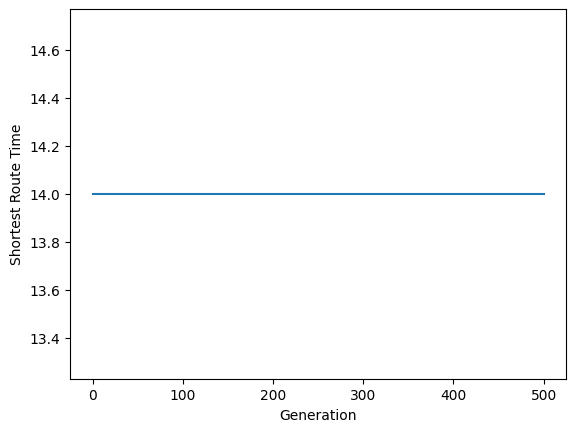

Final shortest time: 14.0
Best route: [El Rosario, Instituto del Petroleo, La Raza, Consulado, Morelos, San Lazaro]


In [32]:
# Define the metro stations and their neighbors with travel times

stations = {
    'El Rosario': Station('El Rosario', {'Tacuba': 4, 'Instituto del Petroleo': 6}),
    'Instituto del Petroleo': Station('Instituto del Petroleo', {'El Rosario': 6, 'Deportivo 18 de Marzo': 2, 'La Raza': 2 }),
    'Deportivo 18 de Marzo': Station('Deportivo 18 de Marzo', {'Instituto del Petroleo': 2 , 'La Raza': 2, 'Martin Carrera': 2 }),
    'Martin Carrera': Station('Martin Carrera', {'Deportivo 18 de Marzo': 2, 'Consulado': 3 }),
    'La Raza': Station('La Raza', {'Deportivo 18 de Marzo': 2, 'Instituto del Petroleo': 2, 'Guerrero': 2, 'Consulado': 3 }),
    'Tacuba': Station('Tacuba', {'El Rosario': 4, 'Hidalgo': 7, 'Tacubaya': 5 }),
    'Consulado': Station('Consulado', {'La Raza': 3, 'Martin Carrera': 3, 'Oceania': 3, 'Morelos': 2 }),
    'Guerrero': Station('Guerrero', {'La Raza': 2, 'Garibaldi': 1, 'Hidalgo': 1 }),
    'Garibaldi': Station('Garibaldi', {'Guerrero': 1, 'Morelos': 3, 'Bellas Artes': 1 }),
    'Morelos': Station('Morelos', {'Garibaldi': 3, 'Consulado': 2, 'San Lazaro': 1, 'Candelaria': 1 }),
    'Oceania': Station('Oceania', {'Consulado': 3, 'Pantitlan': 3, 'San Lazaro': 3 }),
    'Hidalgo': Station('Hidalgo', {'Tacuba': 7, 'Guerrero': 1, 'Bellas Artes': 1, 'Balderas': 2 }),
    'Bellas Artes': Station('Bellas Artes', {'Hidalgo': 1, 'Garibaldi': 1, 'Pino Suarez': 3, 'Salto del Agua': 2 }),
    'Balderas': Station('Balderas', {'Hidalgo': 2, 'Salto del Agua': 1, 'Centro Medico': 3, 'Tacubaya': 6 }),
    'Salto del Agua': Station('Salto del Agua', {'Bellas Artes': 2, 'Pino Suarez': 2, 'Chabacano': 3, 'Balderas': 1}),
    'Pino Suarez': Station('Pino Suarez', {'Bellas Artes': 3, 'Candelaria': 2, 'Chabacano': 2, 'Salto del Agua': 2 }),
    'Candelaria': Station('Candelaria', {'Morelos': 1, 'San Lazaro': 1, 'Jamaica': 2, 'Pino Suarez': 2 }),
    'San Lazaro': Station('San Lazaro', {'Morelos': 1, 'Oceania': 3, 'Pantitlan': 6, 'Candelaria': 1 }),
    'Pantitlan': Station('Pantitlan', {'Oceania': 3, 'Jamaica': 5, 'San Lazaro': 6 }),
    'Tacubaya': Station('Tacubaya', {'Tacuba': 5, 'Balderas': 6, 'Centro Medico': 3, 'Mixcoac': 3 }),
    'Centro Medico': Station('Centro Medico', {'Balderas': 3, 'Chabacano': 2, 'Zapata': 4, 'Tacubaya': 3 }),
    'Chabacano': Station('Chabacano', {'Pino Suarez': 2, 'Jamaica': 1, 'Atlalilco': 8, 'Ermita': 6, 'Centro Medico': 2, 'Salto del Agua': 3 }),
    'Jamaica': Station('Jamaica', {'Candelaria': 2, 'Pantitlan': 5, 'Chabacano': 1 }),
    'Mixcoac': Station('Mixcoac', {'Tacubaya': 3, 'Zapata': 3 }),
    'Zapata': Station('Zapata', {'Centro Medico': 4, 'Ermita': 3, 'Mixcoac': 3 }),
    'Ermita': Station('Ermita', {'Chabacano': 6, 'Atlalilco': 2, 'Zapata': 3 }),
    'Atlalilco': Station('Atlalilco', {'Chabacano': 8, 'Ermita': 2 }),
}


# Create a list of all stations
stationList = [stations[name] for name in stations]
# Define the start and end stations
startStation = stations['El Rosario']
endStation = stations['San Lazaro']

# Run genetic algorithm
route = geneticAlgorithm(stationList, startStation, endStation, popSize=500, eliteSize=20, mutationRate=0.01, generations=100)
print("Best route:", route)

# Run genetic algorithm with plotting
bestRoute = geneticAlgorithmPlot(stationList, startStation, endStation, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
print("Best route:", bestRoute)